In [1]:
#from _supplies import *
from supplies import *
from _util import *

# Set parameters

In [ ]:
import itertools


def main():
    # Define all possible parameters
    #data_setnames = ["Crema-D", "SAVEE", "RAVDESS", "TESS"]
    XAI_methods = ["GradCAM", "Occlusion","CRP"]
    emotions = ['angry','fear','happy',  'neutral', 'sad']
    data_setnames = [ "Crema-D"]  # Uncomment to run only on RAVDESS
    XAI_methods = ["CRP"]
    emotions = ['sad']  
    # Loop over all combinations
    for data_setname, XAI_method, Emotion in itertools.product(
        data_setnames, XAI_methods, emotions
    ):
        print("=========================================")
        print(f"Dataset: {data_setname}")
        print(f"XAI Method: {XAI_method}")
        print(f"Emotion: {Emotion}")
        print("=========================================")
        explanation_analysis(data_setname, XAI_method, Emotion)  

## Explanation Generation

In [6]:
def explanation_analysis(data_setname, XAI_method, Emotion):
    #_____________________________dataset 1____________________________________
    if data_setname == "Crema-D":
        data_path = "data/Crema-D/AudioWAV/" # Path to the audio files for Crema-D
        LABEL_DICT = {0:'fear', 1:'neutral', 2:'happy',3:'angry', 4:'disgust', 5:'surprise',6:'sad'}
        LABELS = list(LABEL_DICT.values())
        #process_dataset(data_path=data_path,data_setname=data_setname)
        ds_train, ds_test, ds_val, dl_train, dl_test, dl_val, LABELS =  process_dataset(data_path='data/Crema-D/AudioWAV/',
                                                                            data_setname='Crema-D',
                                                                            pickle_file='Crema_df.pkl',
                                                                            label_column='Emotions'
                                                                            )
        
        # Load the model
        classes = 7
        model = ResNet(classes)
        checkpoint_path = "checkpoint/best_model_crema.pth"
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint)
        model.to(device)
        model.eval()
        
        # Map emotions to selected instance indices from the test dataset
        # Note: The indices below are based on the dataset's structure and may need adjustment.
        '''instance_map = {
            "sad": 140,
            "neutral": 723,
            "angry": 329,
            "happy": 721,
            "fear": 39,
            "sad": 5,
            "neutral": 12,
            "angry": 6,
            "happy": 1,
            "fear": 42

        }'''

        #True prediction instances
        instance_map = {
            "sad": 140,
            "neutral": 615,
            "angry": 329,
            "happy": 672,
            "fear": 627
        }
        # False prediction instances
        '''instance_map = {
            "sad": 0,
            "neutral": 1,
            "angry": 3,
            "happy": 6,
            "fear": 33
        }'''

        if Emotion not in instance_map:
            raise ValueError("Invalid emotion selected. Choose from 'happy', 'sad', 'angry', 'neutral', or 'fear'.")

        index = instance_map[Emotion]
        ima = ds_test.data[index][1]
        label = ds_test.labels[index]
        data = ds_test.data[index][0]
        
        print(data)
        # Prediction
        pred = get_prediction(model, data=data)
        print(f"Predicted label: {LABEL_DICT[pred]}")
        print(f"True Label: {label} (Maps to: {LABEL_DICT[label]})")

        # XAI
        if XAI_method == "GradCAM":
            windows = GradCAM(model, data, LABEL_DICT, data_setname, LABEL_DICT[label], device)
            print("eGMAPS feature extraction in progress...")
            print("Time steps...", windows)
            # Extract eGMAPS features
            lld1 = extract_egmaps(data, windows, sr=16000)
            # plot selected acoustic features
            plot_feature_bars(lld1, row=0, aggregate=True, top_n=15)
        elif XAI_method == "Occlusion":
            windows = Occlusion_xai(model, data, LABEL_DICT, data_setname, LABEL_DICT[label], device)
            print("eGMAPS feature extraction in progress...")
            print("Time steps...", windows)
            # Extract eGMAPS features
            lld1 = extract_egmaps(data, windows, sr=16000)
            # plot selected acoustic features
            stats = plot_feature_bars(lld1, row=0, aggregate=True, top_n=15)
            print("\n______________\n",stats)
        elif XAI_method == "CRP":
            windows = CRP_xai(model, data, ima, LABEL_DICT, data_setname,LABEL_DICT[label], device)

            print("eGMAPS feature extraction in progress...")
            print("Time steps...", windows)
            # Extract eGMAPS features
            lld1 = extract_egmaps(data, windows, sr=16000)
            # plot selected acoustic features
            stats = plot_feature_bars(lld1, row=0, aggregate=True, top_n=15)
            print("\n___________________________\n",stats,"\n_______________________\n")
            lld2 = Validation(data)
                


        else:
            raise ValueError("Invalid XAI method selected. Choose 'GradCAM' or 'Occlusion'.")
        
 #____________________________________dataset: 2_________________________
    elif data_setname == "TESS":
        data_path = "./data/TESS/tess/tess/"# Path to the audio files for Crema-D
        LABEL_DICT = {0:'fear', 1:'neutral', 2:'happy',3:'angry', 4:'disgust', 5:'surprise',6:'sad'}
        LABELS = list(LABEL_DICT.values())
        ds_train, ds_test, ds_val, dl_train, dl_test, dl_val, LABELS = process_dataset(
                                                                        data_path='data/TESS/tess/tess/',
                                                                        data_setname='TESS',
                                                                        pickle_file='TESS_df.pkl',
                                                                        label_column='Emotions'
                                                                    )
        
        # Load the model
        classes = 7
        model = ResNet(classes)
        checkpoint_path = "checkpoint/best_model_tess.pth"
        model = ResNet(len(LABELS))
        model.load_state_dict(torch.load(checkpoint_path ))
        model.to('cuda')
        model.eval()

        # Emotion and instance selection    
        # Map emotions to selected instance indices from the test dataset
        # True prediction instances
        '''instance_map = {
            "sad": 40,
            "neutral": 68,
            "angry": 17,
            "happy": 96,
            "fear": 7
            
        }'''
        # False prediction instances
        instance_map = {
            "neutral": 68,
            "angry": 2,
            "happy": 3,
            "fear": 4,
            "sad": 0,
        }
        if Emotion not in instance_map:
            raise ValueError("Invalid emotion selected. Choose from 'happy', 'sad', 'angry', 'neutral', or 'fear'.")


        index = instance_map[Emotion]  # here to change  
        ima = ds_test.data[index][1]
        label = ds_test.labels[index]
        data = ds_test.data[index][0]
        pred = get_prediction(model, data = data)
        print(f"Predicted label: {LABEL_DICT[pred]}")
        print("True Label: ",label, "Maps to: ", LABEL_DICT[label])
        #data = "../" + data
        print(data)
        # XAI 
        if XAI_method == "GradCAM":
                windows = GradCAM(model, data, LABEL_DICT, data_setname,LABEL_DICT[label], device)
                print("eGMAPS feature extraction in progress...")
                print("Time steps...", windows)
                # Extract eGMAPS features
                lld1 = extract_egmaps(data, windows, sr=16000)
                # plot selected acoustic features
                plot_feature_bars(lld1, row=0, aggregate=True, top_n=15)
                    
        elif XAI_method == "Occlusion":
                windows = Occlusion_xai(model, data, LABEL_DICT, data_setname,LABEL_DICT[label], device)
                
                print("eGMAPS feature extraction in progress...")
                print("Time steps...", windows)
                # Extract eGMAPS features
                lld1 = extract_egmaps(data, windows, sr=16000)
                # plot selected acoustic features
                stats = plot_feature_bars(lld1, row=0, aggregate=True, top_n=15)
                print("\n______________\n",stats)
        elif XAI_method == "CRP":
                windows = CRP_xai(model, data, ima, LABEL_DICT, data_setname,LABEL_DICT[label], device)
                
                print("eGMAPS feature extraction in progress...")
                print("Time steps...", windows)
                # Extract eGMAPS features
                lld1 = extract_egmaps(data, windows, sr=16000)
                # plot selected acoustic features
                stats = plot_feature_bars(lld1, row=0, aggregate=True, top_n=15)
                print("\n______________\n",stats)
        else:
                raise ValueError("Invalid XAI method selected. Choose either 'GradCAM' or 'Occlusion'.")
    else:
        raise ValueError("Invalid dataset name. Choose from 'Crema-D', 'SAVEE', 'TESS', or 'RAVDESS'.")
           


   

Dataset: Crema-D
XAI Method: CRP
Emotion: sad
data/Crema-D/AudioWAV/1025_TAI_SAD_XX.wav
Predicted label: sad
True Label: 6 (Maps to: sad)
wrt. class 3
Directory already exists: Results_outputs
Top Window Indices: [13, 8, 10, 12, 11]
Time steps for projection (s): [(1.95, 2.1), (1.2, 1.3499999999999999), (1.5, 1.65), (1.7999999999999998, 1.95), (1.65, 1.7999999999999998)]

 time steps length is:  0.15000000000000013


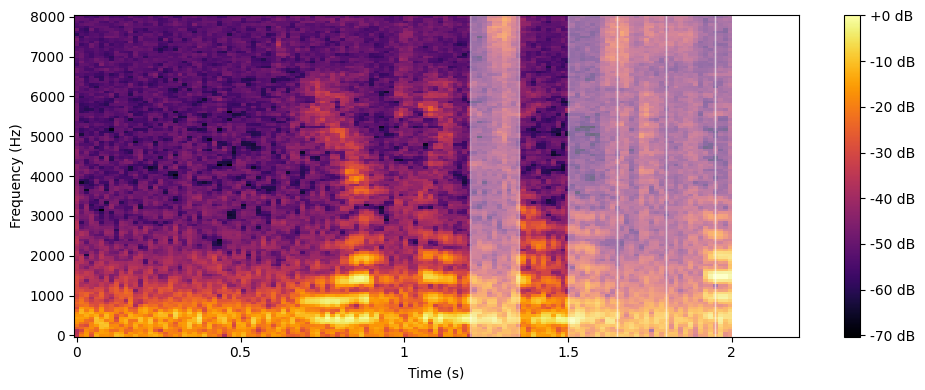

Window Size: 1600, Hop Length: 480, Overlap Length: 1120
lowest_loudness: [(1.8, 1.9), (0.51, 0.61), (0.39, 0.49), (0.48, 0.58), (0.42, 0.52)]
lowest_shrillness: [(1.47, 1.57), (1.44, 1.54), (1.38, 1.48), (0.84, 0.94), (1.41, 1.51)]
Lowest Jitter: [(0.81, 0.91), (0.78, 0.88), (1.86, 1.96), (1.56, 1.66), (0.84, 0.94)]
Lowest Shimmer: [(0.9, 1.0), (1.17, 1.27), (0.57, 0.67), (1.14, 1.24), (0.75, 0.85)]
_____________________Loudness__________________________
The Aligned time interval is:  [1.7999999999999998, 1.95]
[66.66666666666652]
Score:  [66.66666666666652]
Final Explanation Score of Loudness for CRP on Crema-D is:  66.66666666666652
Final Explanation Score coverage rate of Loudness for CRP on Crema-D is:  13.333333333333304
How many intervals that exp windows belongs to in the GT windows for CRP on Crema-D: 1

_____________________Shrillness__________________________
The Aligned time interval is:  [1.5, 1.65]
The Aligned time interval is:  [1.5, 1.65]
The Aligned time interval is:  

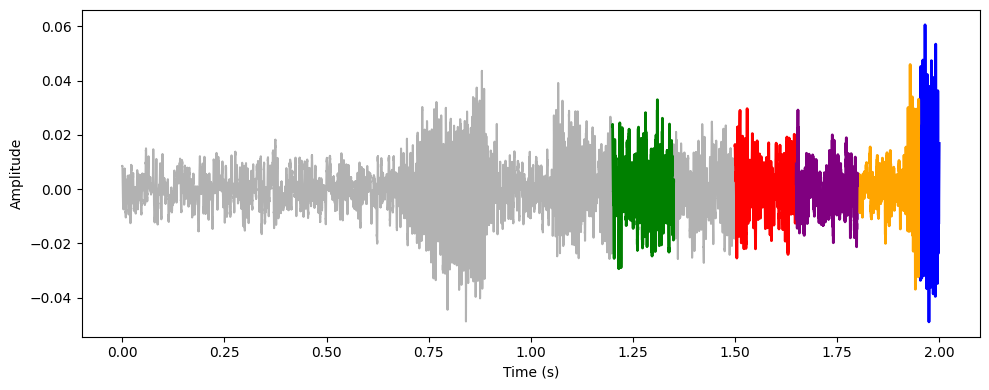

Directory already exists: Results_outputs
eGMAPS feature extraction in progress...
Time steps... [(1.95, 2.1), (1.2, 1.3499999999999999), (1.5, 1.65), (1.7999999999999998, 1.95), (1.65, 1.7999999999999998)]


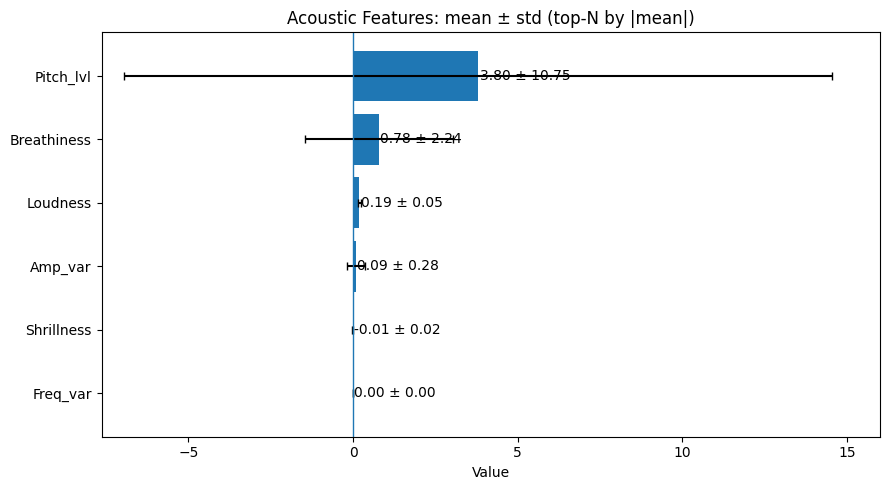


___________________________
                  mean        std
Pitch_lvl    3.803858  10.748186
Breathiness  0.782100   2.240613
Loudness     0.192051   0.047243
Amp_var      0.094940   0.275624
Shrillness  -0.012970   0.020423
Freq_var     0.000915   0.002915 
_______________________


________________________________

All clip Mean eGMAPS feature extraction in progress...
Time steps... [(0.0, 0.15), (0.15, 0.3), (0.3, 0.45), (0.45, 0.6), (0.6, 0.75), (0.75, 0.9), (0.9, 1.05), (1.05, 1.2), (1.2, 1.35), (1.35, 1.5), (1.5, 1.65), (1.65, 1.8), (1.8, 1.95), (1.95, 2.1)]
Plotting random features...
________________________________________


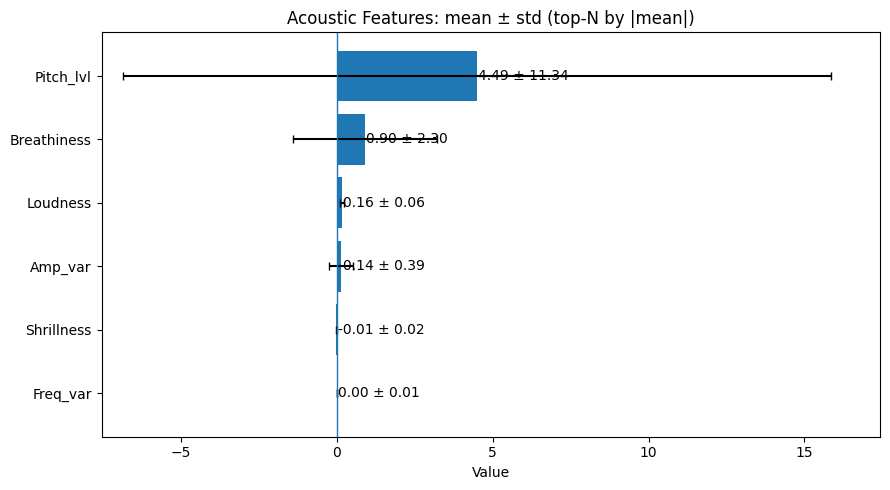


___________All Clip____________
                  mean        std
Pitch_lvl    4.492582  11.344817
Breathiness  0.899476   2.302334
Loudness     0.164348   0.059001
Amp_var      0.143214   0.390892
Shrillness  -0.009707   0.015535
Freq_var     0.001954   0.005797 
_______________________

[(0.0, 0.15), (0.15, 0.3), (0.3, 0.45), (0.45, 0.6), (0.6, 0.75), (0.75, 0.9), (0.9, 1.05), (1.05, 1.2), (1.2, 1.35), (1.35, 1.5), (1.5, 1.65), (1.65, 1.8), (1.8, 1.95), (1.95, 2.1)]


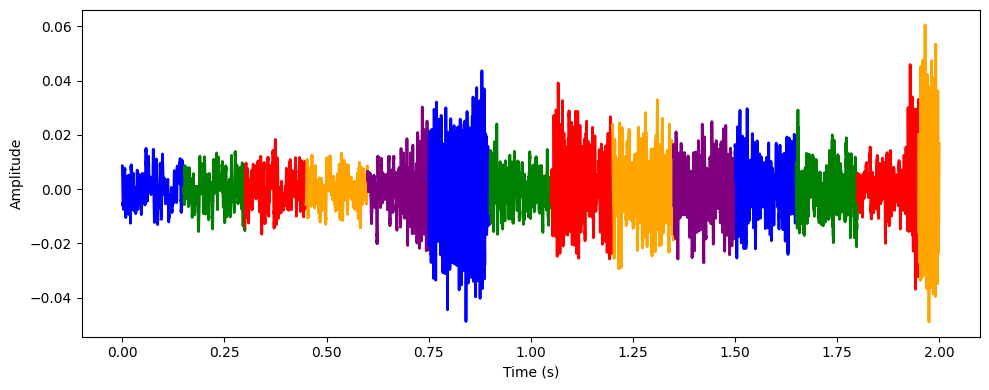

Directory already exists: Results_outputs


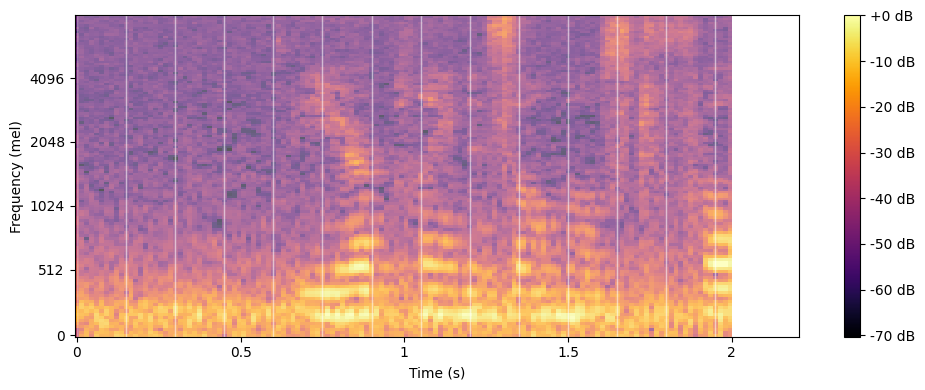

In [7]:
if __name__ == "__main__":
    main()